# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
print(f'Размер выборки {df.shape[0]} фотографий')
display(df.head())
df.describe()

Размер выборки 7591 фотографий


file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

In [3]:
import plotly.express as px

fig = px.histogram(
    df,
    x = 'real_age',
    marginal = 'box',
    opacity = 0.5,
    barmode = 'group',
    title = 'Распределение возраста',
    labels={'real_age': 'Возраст'}
)
fig.show()

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


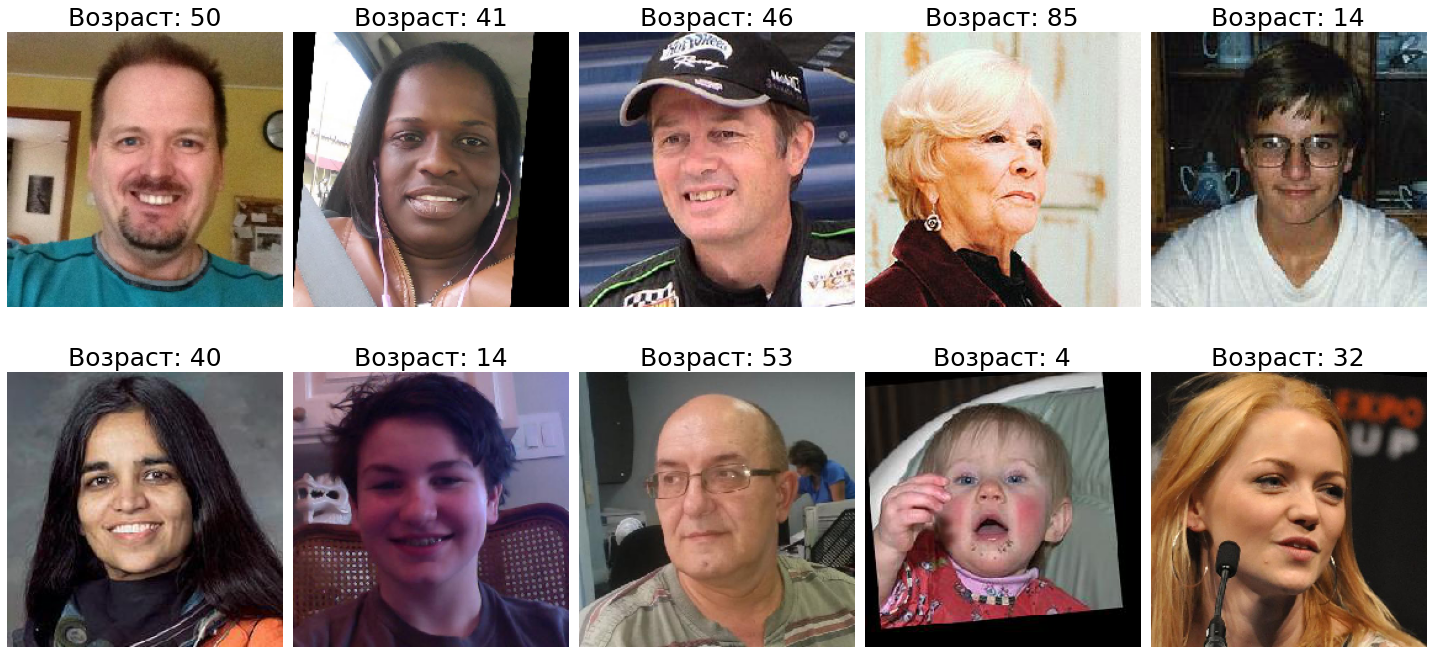

In [5]:
images, labels = next(train_datagen_flow)

plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Возраст: {labels[i]}', fontsize=25)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

Был проведен исследовательский анализ данных:

- в нашем распоряжении 7591 фотография для обучения

- средний возраст **31**

- медианный возраст **29**

- фотографии уже аугментированы, присутствует центрация изображений с заполнением пустот

- в датасете есть люди разного возраста, пола и расс

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25,
        horizontal_flip=True
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow
    
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.25
    )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

    
def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(learning_rate=0.0005)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model
    
    
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=10,
    steps_per_epoch=None,
    validation_steps=None
):
    model.fit( 
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        shuffle=True,
        verbose=2
    )
    
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 74s - loss: 201.3906 - mae: 10.5192 - val_loss: 457.3338 - val_mae: 16.2960
Epoch 2/10
178/178 - 42s - loss: 113.7662 - mae: 8.0596 - val_loss: 351.4040 - val_mae: 13.9385
Epoch 3/10
178/178 - 42s - loss: 90.8156 - mae: 7.2259 - val_loss: 332.9286 - val_mae: 13.5379
Epoch 4/10
178/178 - 42s - loss: 76.6272 - mae: 6.6976 - val_loss: 188.6202 - val_mae: 10.2208
Epoch 5/10
178/178 - 42s - loss: 64.0093 - mae: 6.0994 - val_loss: 122.5364 - val_mae: 8.4303
Epoch 6/10
178/178 - 42s - loss: 47.6193 - mae: 5.2865 - val_loss: 162.3914 - val_mae: 10.2224
Epoch 7/10
178/178 - 42s - loss: 38.7798 - mae: 4.7736 - val_loss: 80.5700 - val_mae: 6.9350
Epoch 8/10
178/178 - 42s - loss: 32.7179 - mae: 4.3741 - val_loss: 85.0522 - val_mae: 6.9282
Epoch 9/10
178/178 - 42s - loss: 28.0688 - mae: 4.0261 - val_loss: 79.4319 - val_mae: 6.9080
Epoch 10/10
178/178 - 42s - loss: 25.7036 - mae: 3.8855 - val_loss: 78.2494 - val_mae: 6.5620

60/60 - 10s - loss: 78.2494 - mae: 6.5620
Test MAE: 6.5620

```

## Анализ обученной модели

Мы достигли метрики 6.56 на тестовых данных за 10 эпох, однако для получения метрики меньше 7 можно остановить модель раньше.


В качестве аугментаций был использован только горизонтальный поворот. В качестве оптимизатора был использован Adam с коэффициентом скорости обучения равным 0.0005, так модель не переобучается и достигает нужной метрики постепенно.


Улучшить результат вероятнее всего можно, если уменьшить скорость обучения и увеличить количество эпох. Так же можно экспериментировать с аугментациями дополнительно, но в нашем случае данные уже хорошо подготовлены.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы